In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def calculate_generation_averages(all_fitness_data):
    """Calculate average fitness for each generation."""
    return [np.mean(fitness_values) for fitness_values in all_fitness_data]

def calculate_generation_standard_errors(all_fitness_data):
    """Calculate standard error for each generation."""
    return [np.std(fitness_values, ddof=1) / np.sqrt(len(fitness_values))
            for fitness_values in all_fitness_data]

def rolling_average_filter(data, window_size):
    """
    Apply a rolling average filter to data with padding.

    Args:
        data: List or array of values to filter
        window_size: Size of the rolling window (should be odd for symmetric filtering)

    Returns:
        List of filtered values with same length as input
    """
    if window_size <= 1:
        return list(data)

    data = list(data)  # Convert to list for easier manipulation

    # Calculate padding needed
    pad_total = window_size - 1
    pad_left = pad_total // 2
    pad_right = pad_total - pad_left  # This handles odd padding by adding extra to the right

    # Pad the data
    padded_data = [data[0]] * pad_left + data + [data[-1]] * pad_right

    # Apply rolling average
    filtered_data = []
    for i in range(len(data)):
        # Get window centered at position i (accounting for padding)
        window_start = i
        window_end = i + window_size
        window = padded_data[window_start:window_end]

        # Calculate average
        avg = sum(window) / len(window)
        filtered_data.append(avg)

    return filtered_data

/nfs/hpc/share/gonzaeve/miniforge/envs/mariners/lib/python3.13/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


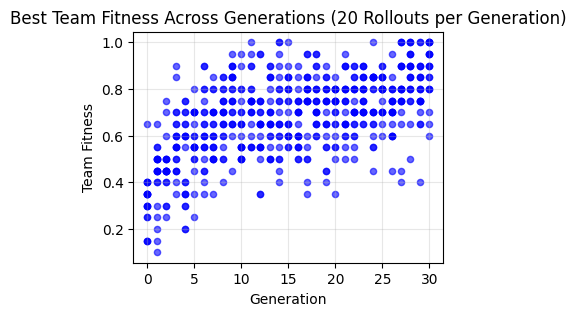

In [56]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Load the data
sorted_fitness_df = pd.read_csv('/nfs/stak/users/gonzaeve/evo-mariners/results/2025-08-13/mike/multiagent/four-agents/trial_0/sorted_fitness.csv')
fitness_df = pd.read_csv('/nfs/stak/users/gonzaeve/evo-mariners/results/2025-08-13/mike/multiagent/four-agents/trial_0/fitness.csv')

# Filter data for generations 0 to 30
sorted_fitness_30 = sorted_fitness_df[sorted_fitness_df['generation'] <= 30].copy()

# Get the best team ID for each generation (sorted_team_0_id)
best_team_ids = sorted_fitness_30['sorted_team_0_id'].tolist()

# print(f"Best team IDs for generations 0-30: {best_team_ids}")
# print(f"Number of generations: {len(best_team_ids)}")

# Create lists to store fitness data
all_fitness_data = []
generation_labels = []

# For each generation, get the fitness data for the best team
for gen in range(len(best_team_ids)):
    team_id = best_team_ids[gen]

    # Get all rows for this generation
    gen_data = fitness_df[fitness_df['generation'] == gen]

    # Extract the 20 rollout fitness values
    gen_fits = []
    for rollout in range(20):
        col_name = f'team_{team_id}_rollout_{rollout}_team_fitness'
        gen_fits.append(gen_data[col_name])

    # Add to our data
    all_fitness_data.append(gen_fits)
    generation_labels.append(gen)

# Create the plot using object-oriented approach
fig, ax = plt.subplots(figsize=(4, 3))

# Iterate through all_fitness_data and plot each group of fitness values
for gen_idx, fitness_values in enumerate(all_fitness_data):
    # Create x values (generation) repeated for each fitness value in this generation
    x_values = [gen_idx] * len(fitness_values)

    # Plot the fitness values for this generation
    ax.scatter(x_values, fitness_values, alpha=0.6, s=20, color='blue')

ax.set_xlabel('Generation')
ax.set_ylabel('Team Fitness')
ax.set_title('Best Team Fitness Across Generations (20 Rollouts per Generation)')
ax.grid(True, alpha=0.3)


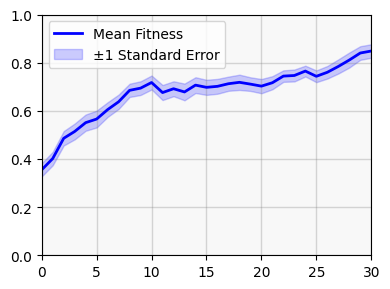

In [55]:
average_fits = calculate_generation_averages(all_fitness_data)
err_fits = calculate_generation_standard_errors(all_fitness_data)

# Add the average line with error bands
generations = range(len(average_fits))

# Add error bands (mean ± standard error)
upper_bound = [avg + err for avg, err in zip(average_fits, err_fits)]
lower_bound = [avg - err for avg, err in zip(average_fits, err_fits)]

# Create the plot using object-oriented approach
fig, ax = plt.subplots(figsize=(4, 3))

window_size = 3  # You can adjust this

# Apply rolling average to all your data
average_fits_smoothed = rolling_average_filter(average_fits, window_size)
upper_bound_smoothed = rolling_average_filter(upper_bound, window_size)
lower_bound_smoothed = rolling_average_filter(lower_bound, window_size)

# Then use the smoothed data in your plot
ax.plot(generations, average_fits_smoothed, color='blue', linewidth=2, label='Mean Fitness')
ax.fill_between(generations, lower_bound_smoothed, upper_bound_smoothed,
                color='blue', alpha=0.2, label='±1 Standard Error')

ax.set_ylim(0,1)
ax.set_xlim(0,30)

# Add legend to show both elements
ax.legend()

# Grid styling to match reference
ax.grid(True, alpha=0.3, linestyle='-', linewidth=1, color='gray')
ax.set_facecolor('#f8f8f8')

# Tighten layout
plt.tight_layout()
plt.show()